# Fine-tuning Bert with GPU to Accelerate Sequence Classification

## Import Packages

#### Support packages

In [1]:
import json
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

#### Data Clearning and utility packages 

In [2]:
import numpy as np
from nltk.tokenize import sent_tokenize
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#### PyTorch packages

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#### HuggingFace Transformer packages

In [26]:
from transformers import BertTokenizer, BertConfig, Pipeline
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

## Some functions for preprocessing

In [5]:
def sentences_to_tokens(sentences, tokenizer, MAX_LEN=128):
    
    #Tokenize text into sentences with [CLS] and [SEP] tokens.
    sentences = [tokenizer.tokenize(f"[CLS] {sent_tokenize(txt)[0]} [SEP]") for txt in sentences]
    
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    tokenized_sentences = [tokenizer.convert_tokens_to_ids(sentence) for sentence in sentences]
    
    #Pad our input tokens
    input_ids = pad_sequences(tokenized_sentences, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    
    return input_ids

def labels_to_one_hot_encoding(labels, dim):
    
    
    encoded_labels = torch.zeros(len(labels), dim)
    for i,label in enumerate(labels):
        encoded_labels[i][label] = 1
        
    return encoded_labels

def decode_labels(labels, key_label):
    
    return [key_label[label] for label in np.argmax(labels)]

def preprocess_data_for_training(data, tokenizer, label_key):
    
    input_ids = sentences_to_tokens(data["text"].values, tokenizer)
    
    labels = labels_to_one_hot_encoding([label_key[label] for label in data["category"].values], len(set(data["category"].values)))
    
    return input_ids, labels

## Class for Training the Model

In [6]:
class ModelTrainer:
    
    _scheduler=None
    _train_data=None
    _validation_data=None
    _train_dataloader=None
    _validation_dataloader=None
    
    train_loss_set=None
    validation_set=None
    
    def __init__(self, input_ids, labels, model, optimizer, scheduler, epochs=4, batch_size=32):
        
        self.model = model
        self.optimizer = optimizer
        self.epochs=epochs
        self.batch_size=batch_size
        
        self.train_inputs, self.validation_inputs, self.train_labels, self.validation_labels = (
            torch.tensor(arr) for arr in train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
        )
    
        attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
        
        self.train_masks, self.validation_masks, _, _ = (
            torch.Tensor(arr) for arr in train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)
        )
        
        self.scheduler = scheduler
        
        
    @property
    def scheduler(self):
        return self._scheduler
    
    @scheduler.setter
    def scheduler(self, scheduler):
        self._scheduler = scheduler(self.optimizer, 
            num_warmup_steps = 0, # Default value in run_glue.py
            num_training_steps = len(self.train_dataloader) * self.epochs)
    
    @property
    def train_data(self):
        if not isinstance(self._train_data, TensorDataset):
            self._train_data = TensorDataset(self.train_inputs, self.train_masks, self.train_labels)
        return self._train_data
    
    @property
    def validation_data(self):
        if not isinstance(self._validation_data, TensorDataset):
            self._validation_data = TensorDataset(self.validation_inputs, self.validation_masks, self.validation_labels) 
        return self._validation_data

    @property
    def train_dataloader(self):
        if not isinstance(self._train_dataloader, DataLoader):
            self._train_dataloader = DataLoader(self.train_data, sampler=RandomSampler(self.train_data), batch_size=self.batch_size)
        return self._train_dataloader
    
    @property
    def validation_dataloader(self):
        if not isinstance(self._validation_dataloader, DataLoader):
            self._validation_dataloader = DataLoader(self.validation_data, sampler=SequentialSampler(self.validation_data), batch_size=self.batch_size)
        return self._validation_dataloader
    
    def _train_model(self):
      # Training
    
        train_loss_set = []

        # Set our model to training mode (as opposed to evaluation mode)
        self.model.train()

        # Tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

      # Train the data for one epoch
        for step, batch in enumerate(self.train_dataloader):
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch
            # Clear out the gradients (by default they accumulate)
            self.optimizer.zero_grad()
            # Forward pass
            outputs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs['loss']
            train_loss_set.append(loss.item())    
            # Backward pass
            loss.backward()
            # Update parameters and take a step using the computed gradient
            self.optimizer.step()

            # Update the learning rate.
            self.scheduler.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss/nb_tr_steps))
        
        return train_loss_set

    @staticmethod
    def _argmax_accuracy(preds, labels):
    
        pred_flat = np.argmax(preds, axis=1).flatten()
        argmax_labels =np.argmax(labels, axis=1)

        return np.sum(pred_flat == argmax_labels) / len(argmax_labels)
    
    def _validate_model(self):
        # Validation
        
        validation_set = []

        # Put model in evaluation mode to evaluate loss on the validation set
        self.model.eval()

        # Tracking variables 
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in self.validation_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch
            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions
                logits = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            # Move logits and labels to CPU
            logits = logits['logits'].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = self._argmax_accuracy(logits, label_ids)
            validation_set.append(tmp_eval_accuracy)

            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

        print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
        
        return validation_set
        

    def train(self):

        # trange is a tqdm wrapper around the normal python range
        self.train_loss_set, self.validation_set = list(),list()
        for _ in trange(self.epochs, desc="Epoch"):

            self.train_loss_set += self._train_model()
            self.validation_set += self._validate_model()
           

## Preparing to Train our Model

#### Specifying CUDA as the device for Torch

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device, torch.cuda.get_device_name(0)

(device(type='cuda'), 'NVIDIA GeForce RTX 3080 Laptop GPU')

#### Use a pretrained tokenizer for preprocessing

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#### Upload our training dataset

In [9]:
with open("review_data.json","r") as file:
    data_df = pd.DataFrame(json.load(file)).T
data_df

,category,text
0,book,This all-Spanish handbook for parents with new...
1,book,McCarthy's writing and portrayal of Lester Bal...
2,book,Do you giggle uncontrollably when poking corps...
3,book,I was initiated into the world of Cormac McCar...
4,book,I cannot speak to the literary points in the n...
...,...,...
70666,kitchen_houseware,What a perfect little machine! I love my CocoM...
70667,kitchen_houseware,I gave this as a gift and was told this makes ...
70668,kitchen_houseware,We got this as a Christmas gift in December an...
70669,kitchen_houseware,I got this little machine when it first came o...


#### For sequence classification, we should define for our scheme for one-hot-encoding our labels

In [10]:
label_key = { category : i for i, category in enumerate(set(data_df["category"])) }
key_label = { i : category for i, category in enumerate(set(data_df["category"])) }

#### Preprocess the training data

In [11]:
input_ids, labels = preprocess_data_for_training(data_df, tokenizer, label_key)

#### Load in the pretrained Bert model

In [12]:
#@title Loading the Hugging Face Bert Uncased Base Model 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Modify the classifier to fit our task

In [13]:
model.classifier = torch.nn.Linear(in_features=768, out_features=4, bias=True)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Define the optimizer

In [14]:
##@title Optimizer Grouped Parameters
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

/home/alex/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training the Model 

#### Create instance of the ModelTrainer

In [15]:
mt = ModelTrainer(
    input_ids=input_ids, 
    labels=labels, 
    model=model, 
    optimizer=optimizer, 
    scheduler=get_linear_schedule_with_warmup, 
    epochs=4, 
    batch_size=32
)

<ipython-input-6-da4a8e3c34c6>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(arr) for arr in train_test_split(input_ids, labels, random_state=2018, test_size=0.1)


#### Train!

In [16]:
mt.train()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.046554163098335266


Epoch:  25%|██▌       | 1/4 [08:45<26:17, 525.88s/it]

Validation Accuracy: 0.916067388493859
Train loss: 0.06810317933559418


Epoch:  50%|█████     | 2/4 [17:33<17:33, 526.86s/it]

Validation Accuracy: 0.9145321590174531
Train loss: 0.03354290500283241


Epoch:  75%|███████▌  | 3/4 [26:23<08:48, 528.24s/it]

Validation Accuracy: 0.9193398513251454
Train loss: 0.00915501918643713


Epoch: 100%|██████████| 4/4 [35:14<00:00, 528.66s/it]

Validation Accuracy: 0.918915643180349


## Some Diagnostics

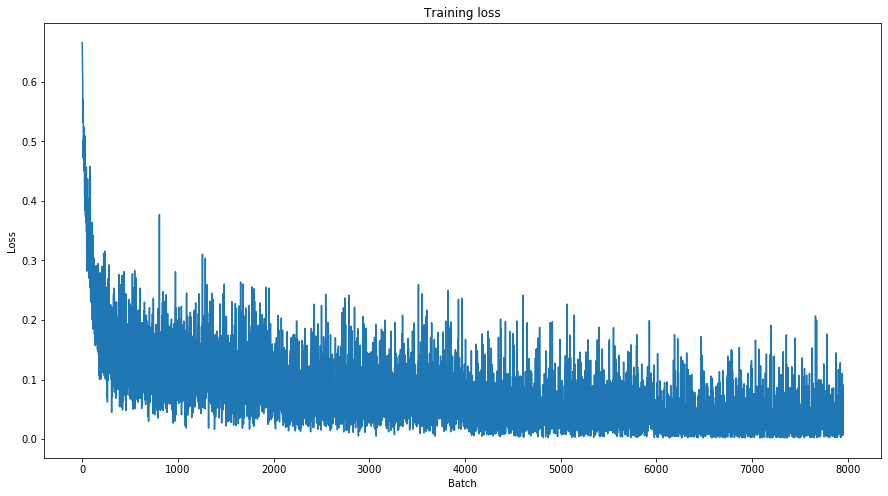

In [24]:


#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(mt.train_loss_set)
plt.show()



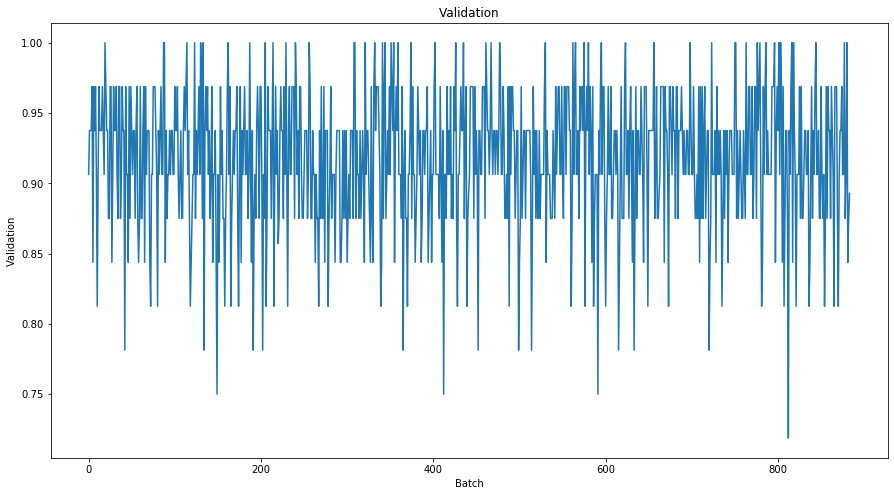

In [116]:


#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Validation")
plt.xlabel("Batch")
plt.ylabel("Validation")
plt.plot(mt.validation_set)
plt.show()



# Deploying our new Model in a custom pipeline

#### Inherit from HuggingFace Pipeline
It is required to override the abstract functions: _sanitize_parameters, __call__, preprocess, _forward, and postprocess.
NOTE: The Pipeline class has a Pipeline.foward function that should not be overriden, but the Pipeline._forward must be.


In [101]:
class CategoryClassificationPipeline(Pipeline):


    def __init__(self, model, key_label):
        
        model.to("cpu")
        self.key_label = key_label
        
        super().__init__(tokenizer=BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True), 
            model=model)

    def _sanitize_parameters(self, return_all_scores=None, **tokenizer_kwargs):
        preprocess_params = tokenizer_kwargs

        postprocess_params = {}

        return preprocess_params, {}, postprocess_params

    def __call__(self, *args, **kwargs):
        result = super().__call__(*args, **kwargs)
        if isinstance(args[0], str):
            # This pipeline is odd, and return a list when single item is run
            return [result]
        else:
            return result

    def preprocess(self, inputs, **tokenizer_kwargs):
        return_tensors = self.framework
        
        if isinstance(inputs, str):
            inputs = f"[CLS] {inputs} [SEP]"
        
        return self.tokenizer(inputs, return_tensors=return_tensors, **tokenizer_kwargs)

    def _forward(self, model_inputs):
        return self.model(**model_inputs)

    def postprocess(self, model_outputs, return_all_scores=False):
        # Default value before `set_parameters`

        outputs = model_outputs["logits"][0]
        outputs = outputs.numpy()
        
        
        return self.key_label[np.argmax(outputs)]


In [102]:
ccp = CategoryClassificationPipeline(model=mt.model, key_label=key_label)

In [169]:
sample_reviews = [
    "It wasn't as good as the book", 
    "This was perfect for storing the mushrooms I foraged in the woods last week",
    "had trouble connecting",
    "It do not know by which way of that emotion filled in my tenure of gathering such info"
]

In [170]:
ccp(sample_reviews)

['dvd', 'kitchen_houseware', 'electronics', 'book']

,category,text
0,book,This all-Spanish handbook for parents with new...
1,book,McCarthy's writing and portrayal of Lester Bal...
2,book,Do you giggle uncontrollably when poking corps...
3,book,I was initiated into the world of Cormac McCar...
4,book,I cannot speak to the literary points in the n...
...,...,...
70666,kitchen_houseware,What a perfect little machine! I love my CocoM...
70667,kitchen_houseware,I gave this as a gift and was told this makes ...
70668,kitchen_houseware,We got this as a Christmas gift in December an...
70669,kitchen_houseware,I got this little machine when it first came o...
